<a href="https://www.kaggle.com/code/dialvedu/pneumonia-detection?scriptVersionId=112053309" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Pneumonia Detection in Chest X-Ray Images

By: Diego Vergara BSc

## Problem description

One of the most important aspects of healthcare, is a timely diagnosis of a disease, as it's easier to treat in early stages. This is not only appliable on cancer, but also in infections, along with other diseases.

Pneumonia is swelling or inflammation of the tissue in one or both lungs. It's usually caused by a bacterial infection, but it can also be caused by a virus. The symptoms of pneumonia can develop suddenly over 24 to 48 hours, or they may come on more slowly over several days. Common symptoms of pneumonia include cough, difficulty breathing, rapid heartbeat, high temperature, sweating, shivering and chest pain, among others. This disease can lead to death, so a prompt diagnosis can increase the chance of fast recovering and survival of the individual.

## Objective

Pneumonia is not easly identified in chest X-ray images, so the objective of this project is to create a model, that could be able to identify from images if a patient has pneumonia or not.

## Data

### Description

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

### Dataset

The dataset was obtained from the Kaggle dataset [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia), which comes from [Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification](https://data.mendeley.com/datasets/rscbjbr9sj/2) from Mendeley Data. According to de description of this dataset, data is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia or Normal). There are 5863 X-Ray images (JPEG) and 2 categories according to de diagnosis (Pneumonia or Normal).

## Set up

In [1]:
import pathlib
import os
import warnings

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from math import ceil
from matplotlib import gridspec
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, plot_roc_curve, plot_confusion_matrix
from IPython.display import Image, display

%matplotlib inline

In [2]:
warnings.filterwarnings("ignore")

train_path = '../input/chest-xray-pneumonia/chest_xray/train'
test_path = '../input/chest-xray-pneumonia/chest_xray/test'
valid_path = '../input/chest-xray-pneumonia/chest_xray/val'

## Exploratory Data Analysis

EDA for images is different from what we can do with structured, text or time series data, so I took into account some [recomendations](https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2) in this matter. The objective of this EDA is to identify differences between images.

### Image Visualization

Firstly, we are going to visualize three random images from each class in order to assess any difference, with a non-medical eye clearly.

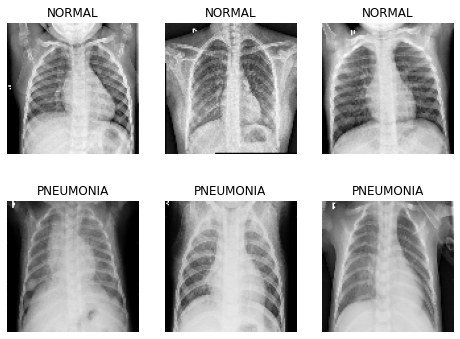

Number of normal images: 1341
Number of pneumonia images: 3875


In [3]:
normal_imgs = [x for x in os.listdir(f'{train_path}/NORMAL') if x.endswith('.jpeg')]
pneumo_imgs = [y for y in os.listdir(f'{train_path}/PNEUMONIA') if y.endswith('.jpeg')]

select_norm = np.random.choice(normal_imgs, 3, replace = False)
select_pneu = np.random.choice(pneumo_imgs, 3, replace = False)

fig = plt.figure(figsize = (8,6))

for i in range(6):
    if i < 3:
        im_path = f'{train_path}/NORMAL/{select_norm[i]}'
        label = 'NORMAL'
    else:
        im_path = f'{train_path}/PNEUMONIA/{select_pneu[i-3]}'
        label = 'PNEUMONIA'
    
    ax = fig.add_subplot(2, 3, i+1)
    
    im = tf.keras.preprocessing.image.load_img(im_path, target_size = (100,100), color_mode='grayscale')
    plt.imshow(im, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')

plt.show()

print(f'Number of normal images: {len(normal_imgs)}')
print(f'Number of pneumonia images: {len(pneumo_imgs)}')

In a first glance, we can se that in Pneumonia images, there is more white spots and noise in the lung area. Also, we have more Pneumonia images than Normal images, so we have a class imbalance that we need to solve.

For the next steps in the analysis, we are going to convert the images in a Numpy Array.

In [4]:
size = (64, 64)

def imgs2np(path, file_list, size = (64, 64)):
    
    for i in file_list:
        image_path = path + i
        image = tf.keras.preprocessing.image.load_img(image_path, target_size = size, color_mode='grayscale')
        image = tf.keras.preprocessing.image.img_to_array(image)
        img_ts = [image.ravel()]
        
        try:
            np_array = np.concatenate((np_array, img_ts))

        except NameError:
            np_array = img_ts    

    return np_array

np_normal_images = imgs2np(f'{train_path}/NORMAL/', normal_imgs)
np_pneumonia_images = imgs2np(f'{train_path}/PNEUMONIA/', pneumo_imgs)

Then, we are going to obtain the mean image and the standard deviation image of both classes.

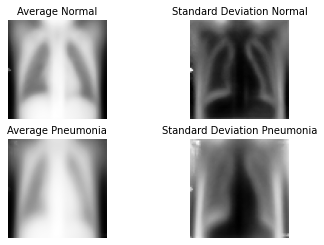

In [5]:
mean_img_norm = np.mean(np_normal_images, axis=0).reshape(size)
mean_img_pneum = np.mean(np_pneumonia_images, axis=0).reshape(size)
std_img_norm = np.std(np_normal_images, axis=0).reshape(size)
std_img_pneum = np.std(np_pneumonia_images, axis=0).reshape(size)

ax = plt.subplot(2, 2, 1)
plt.imshow(mean_img_norm, cmap='Greys_r')
plt.title('Average Normal', fontsize=10)
plt.axis('off')

ax = plt.subplot(2, 2, 2)
plt.imshow(std_img_norm, cmap='Greys_r')
plt.title('Standard Deviation Normal', fontsize=10)
plt.axis('off')

ax = plt.subplot(2, 2, 3)
plt.imshow(mean_img_pneum, cmap='Greys_r')
plt.title('Average Pneumonia', fontsize=10)
plt.axis('off')

ax = plt.subplot(2, 2, 4)
plt.imshow(std_img_pneum, cmap='Greys_r')
plt.title('Standard Deviation Pneumonia', fontsize=10)
plt.axis('off')

plt.show()

We can see from the average images, that in patients without pneumonia the lungs are more clearly defined that those with pneumonia. There is also a higher standard deviation between pneumonia images, making clear the lung damage caused by the disease.

### Contrast Between Images

Now, I am going to compare the contrast between mean images, to get information about their differences.

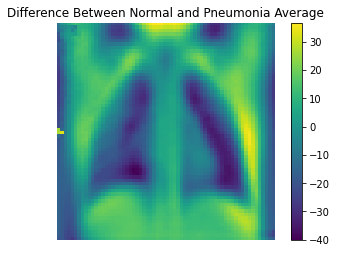

In [6]:
contrast_mean = mean_img_norm - mean_img_pneum
plt.imshow(contrast_mean, cmap='viridis')
plt.title(f'Difference Between Normal and Pneumonia Average')
plt.axis('off')
plt.colorbar()
plt.show()

In the image we can se that there is a negative difference in the lung area, showing there is a higher contrast in this area for pneumonia images.

### Eigenimages

Finally, I am going to analyse the eigenimages from the dataset, with a number of components enough to explain the 70% of the variance in the images.

Number of PC:  28


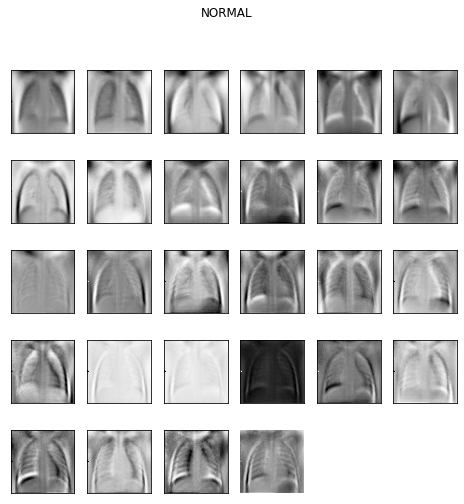

Number of PC:  14


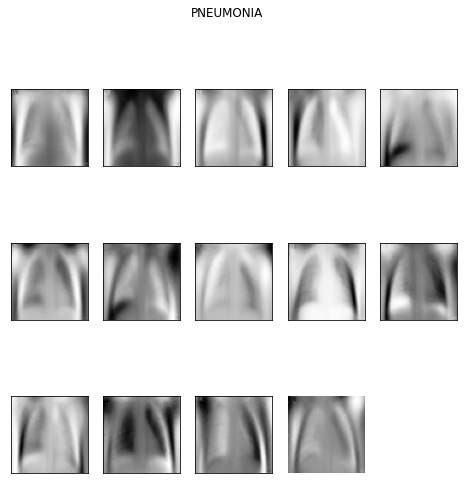

In [7]:
def eigenimages(im, n_comp = 0.7, size = (64, 64)):
    pca = PCA(n_components = n_comp, whiten = True)
    pca.fit(im)
    print('Number of PC: ', pca.n_components_)
    return pca
  
def plot_pca(pca, title, size = (64, 64)):
    n_comp = pca.n_components_
    fig = plt.figure(figsize=(8, 8))
    rows = int(n_comp**0.5)
    cols = ceil(n_comp/rows)
    for i in range(n_comp):
        ax = fig.add_subplot(rows, cols, i + 1, xticks = [], yticks = [])
        ax.imshow(pca.components_[i].reshape(size), 
                  cmap='Greys_r')
    plt.axis('off')
    fig.suptitle(title)
    plt.show()
    
plot_pca(eigenimages(np_normal_images), 'NORMAL')
plot_pca(eigenimages(np_pneumonia_images), 'PNEUMONIA')

From the eigenimages is clear that in Normal patients, the lung area has a well defined contour and rib cage, and in Pneumonia images this area is more diffuse.

## Dataset preparation

Now that we have information about how differentiable are images between them, we can say that a CNN model will have no issues classifying them. Taking this into account, we can prepare the datasets to train and validate the model.

In [8]:
ds_train = image_dataset_from_directory(
    train_path,
    labels='inferred',
    label_mode='binary',
    image_size=(224,224),
    batch_size=32,
    shuffle=True,
)

ds_test = image_dataset_from_directory(
    test_path,
    labels='inferred',
    label_mode='binary',
    image_size=(224,224),
    batch_size=32,
    shuffle=False,
)

ds_valid = image_dataset_from_directory(
    valid_path,
    labels='inferred',
    label_mode='binary',
    image_size=(224,224),
    batch_size=1,
    shuffle=True,
)

Found 5216 files belonging to 2 classes.


2022-11-25 14:04:04.963909: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 14:04:05.113870: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 14:04:05.114686: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 14:04:05.118895: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


I am going to convert the image data to float to get better performance from the model.

In [9]:
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE

ds_train = ds_train.map(convert_to_float).cache().prefetch(buffer_size=AUTOTUNE)
ds_test = ds_test.map(convert_to_float).cache().prefetch(buffer_size=AUTOTUNE)
ds_valid = ds_valid.map(convert_to_float).cache().prefetch(buffer_size=AUTOTUNE)

## Model

One possible approach to this problem is convert the images to structured data, extrating relevant information like contrast, brightness, Fourier transform, among others, but an approach with CNN can help us extract relevant features related to pixel positions, which is what we are seeking when we want to get data from specific areas in the image, and the relationships between pixels in it. Taking this into account, I am going to use TensorFlow to build the classification model.

### Training hyperparameters

As we have a binary classification model, I can define some binary metrics like those from the confussion matrix, and the metrics that derive from it (AUC, Precission, Recall and PR ratio).

In [10]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.BinaryCrossentropy()
metrics = [tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),
           tf.keras.metrics.TruePositives(name='TP'),
           tf.keras.metrics.FalsePositives(name='FP'),
           tf.keras.metrics.TrueNegatives(name='TN'),
           tf.keras.metrics.FalseNegatives(name='FN'),
           tf.keras.metrics.Precision(name='P'),
           tf.keras.metrics.Recall(name='R'),
           tf.keras.metrics.AUC(name='AUC'),
           tf.keras.metrics.AUC(name='PR', curve='PR')
          ]

### Building a CNN

Currently, we have available a lot of pretrained models to extract better insights from image data. But first, the best is to build a CNN to check if a simpler model is enough for this problem. Also, we are going to add some regularization to the convolutional layers, to prevent any overfitting.

In [11]:
model_c = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.Conv2D(8, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_c.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 16)      1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 32)        4

In [12]:
model_c.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history_c = model_c.fit(ds_train,
                        validation_data=ds_test,
                        epochs=50,
                       )

Epoch 1/50


2022-11-25 14:04:10.127359: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-25 14:04:12.521165: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


163/163 [==============================] - 42s 196ms/step - loss: 0.3894 - binary_accuracy: 0.7895 - TP: 3646.0000 - FP: 869.0000 - TN: 472.0000 - FN: 229.0000 - P: 0.8075 - R: 0.9409 - AUC: 0.8682 - PR: 0.9540 - val_loss: 0.8590 - val_binary_accuracy: 0.7596 - val_TP: 357.0000 - val_FP: 117.0000 - val_TN: 117.0000 - val_FN: 33.0000 - val_P: 0.7532 - val_R: 0.9154 - val_AUC: 0.8590 - val_PR: 0.8910
Epoch 2/50
163/163 [==============================] - 3s 19ms/step - loss: 0.2483 - binary_accuracy: 0.9310 - TP: 3709.0000 - FP: 194.0000 - TN: 1147.0000 - FN: 166.0000 - P: 0.9503 - R: 0.9572 - AUC: 0.9712 - PR: 0.9906 - val_loss: 0.9647 - val_binary_accuracy: 0.7548 - val_TP: 378.0000 - val_FP: 141.0000 - val_TN: 93.0000 - val_FN: 12.0000 - val_P: 0.7283 - val_R: 0.9692 - val_AUC: 0.8781 - val_PR: 0.8941
Epoch 3/50
163/163 [==============================] - 3s 20ms/step - loss: 0.2125 - binary_accuracy: 0.9536 - TP: 3773.0000 - FP: 140.0000 - TN: 1201.0000 - FN: 102.0000 - P: 0.9642 - R: 

<AxesSubplot:>

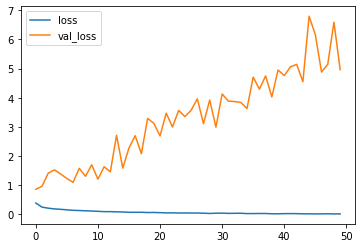

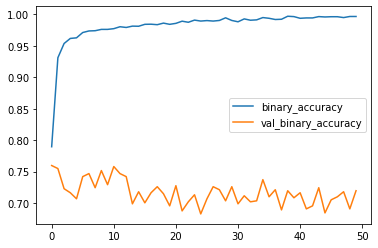

In [13]:
history_frame_c = pd.DataFrame(history_c.history)
history_frame_c.loc[:, ['loss', 'val_loss']].plot()
history_frame_c.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()

In this model, I added five convolutional layers to have a simillar structure of pretrained models for computer vision, but clearly this model is overfitting, so I will add some regularization, with some arbitrary constants, to the classification head, as the plot shows that the problem will not be solved with an early stopping callback.

In [14]:
regularizer = tf.keras.regularizers.L1L2(l1=0.01, l2=0.01)

model_c_2 = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.Conv2D(8, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizer),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_c_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
random_flip_1 (RandomFlip)   (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 224, 224, 8)       224       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 8)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 112, 112, 16)      1168      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 56, 56, 32)       

In [15]:
model_c_2.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history_c_2 = model_c_2.fit(ds_train,
                            validation_data=ds_test,
                            epochs=50,
                           )

Epoch 1/50
163/163 [==============================] - 6s 26ms/step - loss: 1.7436 - binary_accuracy: 0.7330 - TP: 4192.0000 - FP: 1486.0000 - TN: 89.0000 - FN: 73.0000 - P: 0.7383 - R: 0.9829 - AUC: 0.7066 - PR: 0.8455 - val_loss: 0.8796 - val_binary_accuracy: 0.6250 - val_TP: 390.0000 - val_FP: 234.0000 - val_TN: 0.0000e+00 - val_FN: 0.0000e+00 - val_P: 0.6250 - val_R: 1.0000 - val_AUC: 0.8749 - val_PR: 0.9327
Epoch 2/50
163/163 [==============================] - 3s 20ms/step - loss: 0.6738 - binary_accuracy: 0.8037 - TP: 3621.0000 - FP: 770.0000 - TN: 571.0000 - FN: 254.0000 - P: 0.8246 - R: 0.9345 - AUC: 0.8994 - PR: 0.9655 - val_loss: 0.8427 - val_binary_accuracy: 0.8141 - val_TP: 331.0000 - val_FP: 57.0000 - val_TN: 177.0000 - val_FN: 59.0000 - val_P: 0.8531 - val_R: 0.8487 - val_AUC: 0.8767 - val_PR: 0.9251
Epoch 3/50
163/163 [==============================] - 3s 19ms/step - loss: 0.6047 - binary_accuracy: 0.8842 - TP: 3525.0000 - FP: 254.0000 - TN: 1087.0000 - FN: 350.0000 - P: 

<AxesSubplot:>

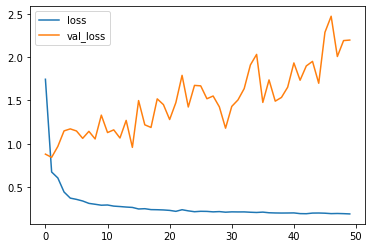

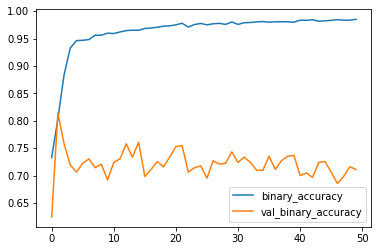

In [16]:
history_frame_c_2 = pd.DataFrame(history_c_2.history)
history_frame_c_2.loc[:, ['loss', 'val_loss']].plot()
history_frame_c_2.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()

The model is still overfitting, so before trying any further regularization, I will evaluate how transfer learning can solve this problem. In [Yadav & Jadhav, in 2019](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-019-0276-2#Sec15), they stated that VGG16 has a great performance for medical images.

### Transfer learning - VGG16

In [17]:
inputs = tf.keras.Input(shape=(224,224,3))
net = tf.keras.layers.Rescaling(1./255)(inputs)
net = tf.keras.layers.RandomFlip('horizontal')(net)

pretrained_base = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                    pooling='avg',
                                                    input_tensor=net
                                                   )
pretrained_base.trainable = False

net = tf.keras.layers.Dropout(0.2)(pretrained_base.output)
net = tf.keras.layers.Dense(16, activation='relu')(net)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(net)

model_t = tf.keras.Model(inputs, outputs)

model_t.summary()

58900480/58889256 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
random_flip_2 (RandomFlip)   (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
______________________________________________________________

In [18]:
model_t.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [19]:
history_t = model_t.fit(ds_train,
                        validation_data=ds_test,
                        epochs=50,
                       )

Epoch 1/50
163/163 [==============================] - 19s 89ms/step - loss: 0.2882 - binary_accuracy: 0.8572 - TP: 4093.0000 - FP: 662.0000 - TN: 913.0000 - FN: 172.0000 - P: 0.8608 - R: 0.9597 - AUC: 0.8715 - PR: 0.9112 - val_loss: 0.3829 - val_binary_accuracy: 0.8333 - val_TP: 382.0000 - val_FP: 96.0000 - val_TN: 138.0000 - val_FN: 8.0000 - val_P: 0.7992 - val_R: 0.9795 - val_AUC: 0.9399 - val_PR: 0.9605
Epoch 2/50
163/163 [==============================] - 12s 76ms/step - loss: 0.1850 - binary_accuracy: 0.9287 - TP: 3711.0000 - FP: 208.0000 - TN: 1133.0000 - FN: 164.0000 - P: 0.9469 - R: 0.9577 - AUC: 0.9743 - PR: 0.9911 - val_loss: 0.3844 - val_binary_accuracy: 0.8349 - val_TP: 382.0000 - val_FP: 95.0000 - val_TN: 139.0000 - val_FN: 8.0000 - val_P: 0.8008 - val_R: 0.9795 - val_AUC: 0.9467 - val_PR: 0.9630
Epoch 3/50
163/163 [==============================] - 12s 74ms/step - loss: 0.1640 - binary_accuracy: 0.9350 - TP: 3724.0000 - FP: 188.0000 - TN: 1153.0000 - FN: 151.0000 - P: 0.9

<AxesSubplot:>

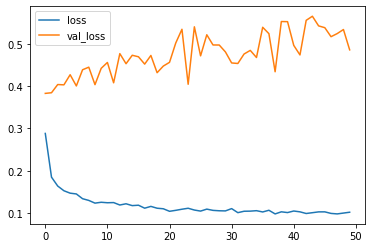

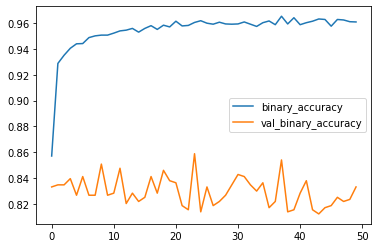

In [20]:
history_frame_t = pd.DataFrame(history_t.history)
history_frame_t.loc[:, ['loss', 'val_loss']].plot()
history_frame_t.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()

In [21]:
model_t.evaluate(ds_valid, verbose=True)

16/16 [==============================] - 1s 15ms/step - loss: 0.6857 - binary_accuracy: 0.7500 - TP: 8.0000 - FP: 4.0000 - TN: 4.0000 - FN: 0.0000e+00 - P: 0.6667 - R: 1.0000 - AUC: 0.9844 - PR: 0.9853


[0.6856768727302551,
 0.75,
 8.0,
 4.0,
 4.0,
 0.0,
 0.6666666865348816,
 1.0,
 0.984375,
 0.9852771162986755]

### Training VGG 16

In [22]:
inputs = tf.keras.Input(shape=(224,224,3))
net = tf.keras.layers.Rescaling(1./255)(inputs)
net = tf.keras.layers.RandomFlip('horizontal')(net)

pretrained_base = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                    pooling='avg',
                                                    input_tensor=net
                                                   )
pretrained_base.trainable = True

net = tf.keras.layers.Dropout(0.2)(pretrained_base.output)
net = tf.keras.layers.Dense(16, activation='relu')(net)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(net)

model_t_2 = tf.keras.Model(inputs, outputs)

model_t_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
random_flip_3 (RandomFlip)   (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     7385

In [23]:
model_t_2.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [24]:
history_t_2 = model_t_2.fit(ds_train,
                            validation_data=ds_test,
                            epochs=50,
                           )

Epoch 1/50
163/163 [==============================] - 39s 219ms/step - loss: 3596.0847 - binary_accuracy: 0.7185 - TP: 3703.0000 - FP: 1293.0000 - TN: 56.0000 - FN: 180.0000 - P: 0.7412 - R: 0.9536 - AUC: 0.4895 - PR: 0.7359 - val_loss: 0.6629 - val_binary_accuracy: 0.6250 - val_TP: 390.0000 - val_FP: 234.0000 - val_TN: 0.0000e+00 - val_FN: 0.0000e+00 - val_P: 0.6250 - val_R: 1.0000 - val_AUC: 0.5000 - val_PR: 0.6250
Epoch 2/50
163/163 [==============================] - 35s 213ms/step - loss: 0.6009 - binary_accuracy: 0.7429 - TP: 3875.0000 - FP: 1341.0000 - TN: 0.0000e+00 - FN: 0.0000e+00 - P: 0.7429 - R: 1.0000 - AUC: 0.4980 - PR: 0.7431 - val_loss: 0.6627 - val_binary_accuracy: 0.6250 - val_TP: 390.0000 - val_FP: 234.0000 - val_TN: 0.0000e+00 - val_FN: 0.0000e+00 - val_P: 0.6250 - val_R: 1.0000 - val_AUC: 0.5000 - val_PR: 0.6250
Epoch 3/50
163/163 [==============================] - 35s 213ms/step - loss: 7.3308 - binary_accuracy: 0.7429 - TP: 3875.0000 - FP: 1341.0000 - TN: 0.0000e+

<AxesSubplot:>

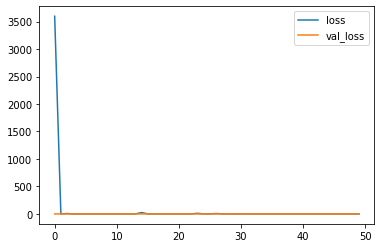

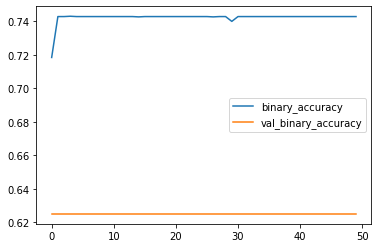

In [25]:
history_frame_t_2 = pd.DataFrame(history_t_2.history)
history_frame_t_2.loc[:, ['loss', 'val_loss']].plot()
history_frame_t_2.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()

In [26]:
model_t_2.evaluate(ds_valid, verbose=True)

16/16 [==============================] - 0s 9ms/step - loss: 0.8279 - binary_accuracy: 0.5000 - TP: 8.0000 - FP: 8.0000 - TN: 0.0000e+00 - FN: 0.0000e+00 - P: 0.5000 - R: 1.0000 - AUC: 0.5000 - PR: 0.5000


[0.8279252648353577, 0.5, 8.0, 8.0, 0.0, 0.0, 0.5, 1.0, 0.5, 0.5]

### Transfer learning - VGG16 Max pool

In [27]:
inputs = tf.keras.Input(shape=(224,224,3))
net = tf.keras.layers.Rescaling(1./255)(inputs)
net = tf.keras.layers.RandomFlip('horizontal')(net)

pretrained_base = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                    pooling='max',
                                                    input_tensor=net
                                                   )
pretrained_base.trainable = False

net = tf.keras.layers.Dropout(0.2)(pretrained_base.output)
net = tf.keras.layers.Dense(16, activation='relu')(net)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(net)

model_t_3 = tf.keras.Model(inputs, outputs)

model_t_3.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
rescaling_4 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
random_flip_4 (RandomFlip)   (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     7385

In [28]:
model_t_3.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [29]:
history_t_3 = model_t_3.fit(ds_train,
                            validation_data=ds_test,
                            epochs=50,
                           )

Epoch 1/50
163/163 [==============================] - 15s 79ms/step - loss: 0.2271 - binary_accuracy: 0.9025 - TP: 3687.0000 - FP: 314.0000 - TN: 1035.0000 - FN: 196.0000 - P: 0.9215 - R: 0.9495 - AUC: 0.9566 - PR: 0.9836 - val_loss: 0.5333 - val_binary_accuracy: 0.7885 - val_TP: 388.0000 - val_FP: 130.0000 - val_TN: 104.0000 - val_FN: 2.0000 - val_P: 0.7490 - val_R: 0.9949 - val_AUC: 0.9398 - val_PR: 0.9541
Epoch 2/50
163/163 [==============================] - 12s 74ms/step - loss: 0.1452 - binary_accuracy: 0.9459 - TP: 3751.0000 - FP: 158.0000 - TN: 1183.0000 - FN: 124.0000 - P: 0.9596 - R: 0.9680 - AUC: 0.9827 - PR: 0.9937 - val_loss: 0.4062 - val_binary_accuracy: 0.8413 - val_TP: 384.0000 - val_FP: 93.0000 - val_TN: 141.0000 - val_FN: 6.0000 - val_P: 0.8050 - val_R: 0.9846 - val_AUC: 0.9436 - val_PR: 0.9610
Epoch 3/50
163/163 [==============================] - 12s 74ms/step - loss: 0.1366 - binary_accuracy: 0.9482 - TP: 3750.0000 - FP: 145.0000 - TN: 1196.0000 - FN: 125.0000 - P: 0

<AxesSubplot:>

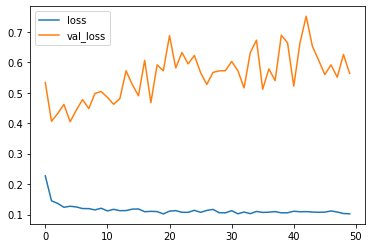

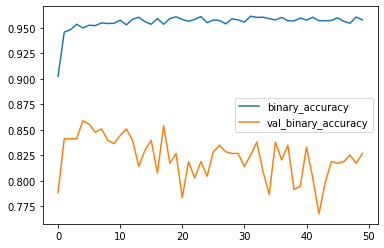

In [30]:
history_frame_t_3 = pd.DataFrame(history_t_3.history)
history_frame_t_3.loc[:, ['loss', 'val_loss']].plot()
history_frame_t_3.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()

In [31]:
model_t_3.evaluate(ds_valid, verbose=True)

16/16 [==============================] - 0s 9ms/step - loss: 0.8090 - binary_accuracy: 0.6875 - TP: 8.0000 - FP: 5.0000 - TN: 3.0000 - FN: 0.0000e+00 - P: 0.6154 - R: 1.0000 - AUC: 1.0000 - PR: 1.0000


[0.8089630603790283,
 0.6875,
 8.0,
 5.0,
 3.0,
 0.0,
 0.6153846383094788,
 1.0,
 1.0,
 1.0]

### Transfer learing VGG16 - Avg Pool, Regularization

In [32]:
regularizer = tf.keras.regularizers.L1L2(l2=0.01)

inputs = tf.keras.Input(shape=(224,224,3))
net = tf.keras.layers.Rescaling(1./255)(inputs)
net = tf.keras.layers.RandomFlip('horizontal')(net)

pretrained_base = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                    pooling='avg',
                                                    input_tensor=net
                                                   )
pretrained_base.trainable = False

net = tf.keras.layers.Dropout(0.2)(pretrained_base.output)
net = tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizer)(net)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(net)

model_t_4 = tf.keras.Model(inputs, outputs)

model_t_4.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
rescaling_5 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
random_flip_5 (RandomFlip)   (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     7385

In [33]:
model_t_4.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [34]:
history_t_4 = model_t_4.fit(ds_train,
                            validation_data=ds_test,
                            epochs=50,
                           )

Epoch 1/50
163/163 [==============================] - 15s 79ms/step - loss: 0.4269 - binary_accuracy: 0.8427 - TP: 3713.0000 - FP: 653.0000 - TN: 696.0000 - FN: 170.0000 - P: 0.8504 - R: 0.9562 - AUC: 0.9172 - PR: 0.9694 - val_loss: 0.4737 - val_binary_accuracy: 0.8157 - val_TP: 382.0000 - val_FP: 107.0000 - val_TN: 127.0000 - val_FN: 8.0000 - val_P: 0.7812 - val_R: 0.9795 - val_AUC: 0.9331 - val_PR: 0.9548
Epoch 2/50
163/163 [==============================] - 12s 73ms/step - loss: 0.3299 - binary_accuracy: 0.8911 - TP: 3690.0000 - FP: 383.0000 - TN: 958.0000 - FN: 185.0000 - P: 0.9060 - R: 0.9523 - AUC: 0.9530 - PR: 0.9836 - val_loss: 0.4516 - val_binary_accuracy: 0.8221 - val_TP: 382.0000 - val_FP: 103.0000 - val_TN: 131.0000 - val_FN: 8.0000 - val_P: 0.7876 - val_R: 0.9795 - val_AUC: 0.9388 - val_PR: 0.9585
Epoch 3/50
163/163 [==============================] - 12s 74ms/step - loss: 0.3114 - binary_accuracy: 0.8969 - TP: 3686.0000 - FP: 349.0000 - TN: 992.0000 - FN: 189.0000 - P: 0.9

<AxesSubplot:>

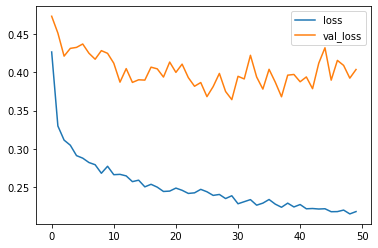

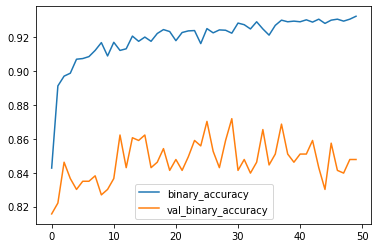

In [35]:
history_frame_t_4 = pd.DataFrame(history_t_4.history)
history_frame_t_4.loc[:, ['loss', 'val_loss']].plot()
history_frame_t_4.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()

In [36]:
model_t_4.evaluate(ds_valid, verbose=True)

16/16 [==============================] - 0s 13ms/step - loss: 0.6919 - binary_accuracy: 0.6875 - TP: 8.0000 - FP: 5.0000 - TN: 3.0000 - FN: 0.0000e+00 - P: 0.6154 - R: 1.0000 - AUC: 0.9688 - PR: 0.9686


[0.6919026970863342,
 0.6875,
 8.0,
 5.0,
 3.0,
 0.0,
 0.6153846383094788,
 1.0,
 0.96875,
 0.968585729598999]

## Visualization and Explainability

In [37]:
def get_img_array(img_path, size):
    
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        model.inputs,
        [model.get_layer(last_conv_layer_name).output,
         model.output
        ]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        p = grad_model(img_array)
        last_conv_layer_output = p[0]
        preds = p[1]
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, size, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    
    # Display Grad-CAM
    
    plt.imshow(superimposed_img)
    plt.axis('off')

In [38]:
normal_imgs_val = [x for x in os.listdir(f'{valid_path}/NORMAL') if x.endswith('.jpeg')]
pneumo_imgs_val = [y for y in os.listdir(f'{valid_path}/PNEUMONIA') if y.endswith('.jpeg')]

select_norm_val = np.random.choice(normal_imgs_val, 1, replace = False)
select_pneu_val = np.random.choice(pneumo_imgs_val, 1, replace = False)

path = f'{valid_path}/NORMAL/{select_norm_val[0]}'

img_array = get_img_array(path, size=(224, 224, 3))

heatmap = make_gradcam_heatmap(img_array, model_t_4, 'block5_conv3')

Text(0.5, 1.0, 'Normal')

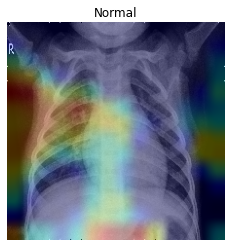

In [39]:
display_gradcam(path, heatmap, size=(224,224))
plt.title('Normal')

In [40]:
path = f'{valid_path}/PNEUMONIA/{select_pneu_val[0]}'

img_array = get_img_array(path, size=(224, 224, 3))

heatmap = make_gradcam_heatmap(img_array, model_t_4, 'block5_conv3')

Text(0.5, 1.0, 'Pneumonia')

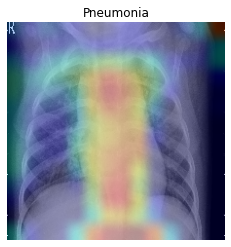

In [41]:
display_gradcam(path, heatmap, size=(224,224))
plt.title('Pneumonia')

# References

1. NHS, “Pneumonia,” NHS choices. [Online]. Available: https://www.nhs.uk/conditions/pneumonia/. [Accessed: 20-Jan-2022].

2. E. Byeon, “Exploratory data analysis ideas for image classification,” Medium, 11-Sep-2020. [Online]. Available: https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2. [Accessed: 21-Jan-2022].

3. Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification”, Mendeley Data, V2, doi: 10.17632/rscbjbr9sj.2

4. Yadav, S.S., Jadhav, S.M. Deep convolutional neural network based medical image classification for disease diagnosis. J Big Data 6, 113 (2019). https://doi.org/10.1186/s40537-019-0276-2